## Imports

In [2]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchviz import make_dot
from torch import optim
import matplotlib.pyplot as plt



from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

In [3]:
%load_ext autoreload
%autoreload 2

## Toy data


In [13]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 1000, batch_size = 100, r = 100)

## Training

### PICNN training

In [5]:
epochs = 25

# Initialize the model
model = ICNNet(input_size=2, layer_sizes = [2,4,2], context_layer_sizes=[2,2,2])
model.train()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)
        
        #pass

    #for name, parameter in model.named_parameters():
        #if parameter.requires_grad and parameter.grad is not None:
            #grad_norm = parameter.grad.norm().item()
            #print(f"Gradient norm for {name}: {grad_norm}")

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")




Epoch 1/25 Loss: 54.05063247680664
Epoch 2/25 Loss: 47.48914337158203
Epoch 3/25 Loss: 42.38894271850586
Epoch 4/25 Loss: 31.513731002807617
Epoch 5/25 Loss: 30.66090965270996
Epoch 6/25 Loss: 28.415199279785156
Epoch 7/25 Loss: 26.73316192626953
Epoch 8/25 Loss: 30.48093032836914
Epoch 9/25 Loss: 30.53807258605957
Epoch 10/25 Loss: 28.5042724609375
Epoch 11/25 Loss: 22.54220962524414
Epoch 12/25 Loss: 23.615636825561523
Epoch 13/25 Loss: 21.875471115112305
Epoch 14/25 Loss: 23.777734756469727
Epoch 15/25 Loss: 23.197723388671875
Epoch 16/25 Loss: 18.730249404907227
Epoch 17/25 Loss: 20.191713333129883
Epoch 18/25 Loss: 15.468118667602539
Epoch 19/25 Loss: 10.96141242980957
Epoch 20/25 Loss: 11.26916790008545
Epoch 21/25 Loss: 9.50964641571045
Epoch 22/25 Loss: 10.085987091064453
Epoch 23/25 Loss: 8.588666915893555
Epoch 24/25 Loss: 8.194286346435547
Epoch 25/25 Loss: 8.3175630569458


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Suppose 'model' is your PyTorch model
num_parameters = count_parameters(model)

print(f'The model has {num_parameters} parameters')

The model has 88 parameters


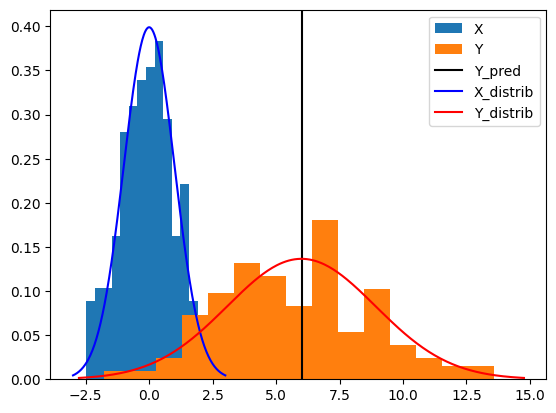

In [8]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C


Y_pred  = model(X, C)[0, :, 0].detach().numpy().mean()

plt.hist(X[0, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[0, :, 0],  bins=15, label = 'Y', density = True)
plt.axvline(x = Y_pred, color = 'black', label = 'Y_pred')
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), stats.norm.pdf(np.linspace(-3*scales[0, 0] + locs[0, 0], 3*scales[0, 0] + locs[0, 0], 300), loc=locs[0, 0], scale=scales[0, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()
         





In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x_batch, c_batch, y_batch in dataloader:
        outputs = model(x_batch, c_batch)
        for result, y in zip(outputs, y_batch) :
            print(result, y)
        break



tensor([[-4.0073, -5.0977],
        [-4.0027, -5.0684],
        [-3.9708, -4.9555],
        [-4.0040, -5.0634],
        [-3.9747, -4.9609],
        [-4.0126, -5.1464],
        [-3.9838, -4.9873],
        [-3.9946, -5.0345],
        [-3.9965, -5.0441],
        [-3.9656, -4.9447],
        [-3.9849, -4.9985],
        [-3.9808, -4.9717],
        [-3.9997, -5.0674],
        [-4.0031, -5.0552],
        [-4.0043, -5.0720],
        [-3.9866, -5.0062],
        [-4.0096, -5.1208],
        [-3.9948, -5.0393],
        [-3.9939, -5.0142],
        [-3.9998, -5.0462],
        [-3.9786, -4.9745],
        [-3.9809, -4.9833],
        [-3.9797, -4.9840],
        [-4.0014, -5.0631],
        [-4.0074, -5.0930],
        [-3.9672, -4.9297],
        [-3.9998, -5.0630],
        [-3.9653, -4.9462],
        [-4.0028, -5.0603],
        [-3.9950, -5.0309],
        [-3.9662, -4.9324],
        [-3.9829, -4.9930],
        [-4.0104, -5.1084],
        [-3.9884, -4.9921],
        [-3.9932, -5.0228],
        [-3.9863, -4

### Makkuva

In [14]:
epochs = 25
train_freq_g = 20

# Initialize the model
input_size = 2
ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 4,8,32,64,2], context_layer_sizes=[2,4,8,32,64,2])

output_size = 2

ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size, 4,8,32,64,2], context_layer_sizes=[2,4,8,32,64,2])

#ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2])

#ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size, 2, 2, 2,2], context_layer_sizes=[2,2, 2, 2,2]) 

print(f'The model has {count_parameters(ICNNf)} parameters')
# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters())
optimizer_g = optim.Adam(ICNNg.parameters())

for epoch in range(epochs):
    for _ in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = -ICNNf(grad_g, c) - torch.mul(y, grad_g).sum(-1, keepdim=True)
            loss_g = torch.mean(loss_g)

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        diff_output_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        loss_f = ICNNf(x, c) - ICNNf(diff_output_g, c)
        loss_f = torch.mean(loss_f)

        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)



        #testing algorithm
        # output_g_test = ICNNg(x, c)
        # diff_output_g_test = torch.autograd.grad(output_g_test, x, grad_outputs=torch.ones_like(output_g_test), create_graph=True)[0]

        # loss_test = diff_output_g_test-y

        #print('y =', y[0], 'diff_output_g =', diff_output_g_test[0])
        
        pass

    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

The model has 128 parameters


Epoch 1/25 loss_g: -2.121105194091797, loss_f: -0.10911950469017029
Epoch 2/25 loss_g: -63.03780746459961, loss_f: 0.9428404569625854
Epoch 3/25 loss_g: -786859.125, loss_f: -1276.328857421875
Epoch 4/25 loss_g: -16653923328.0, loss_f: -395761984.0
Epoch 5/25 loss_g: -4207900098560.0, loss_f: -42641195008.0
Epoch 6/25 loss_g: -95134112808960.0, loss_f: -2608461774848.0
Epoch 7/25 loss_g: -2182397302931456.0, loss_f: -33219214835712.0
Epoch 8/25 loss_g: -1.10058000089088e+16, loss_f: -311136322846720.0
Epoch 9/25 loss_g: -1.101182284154798e+17, loss_f: -2570916689084416.0
Epoch 10/25 loss_g: -3.7411563457898086e+17, loss_f: -1.0808527866036224e+16
Epoch 11/25 loss_g: -2.2365702032510157e+18, loss_f: -4.599837389068698e+16
Epoch 12/25 loss_g: -4.802286359102358e+18, loss_f: -1.5882387051669094e+17
Epoch 13/25 loss_g: -1.4563019415265214e+19, loss_f: -5.311218749360046e+17
Epoch 14/25 loss_g: -4.492225399483479e+19, loss_f: -1.5679516848422912e+18
Epoch 15/25 loss_g: -8.140604651755851e+1

[ 0.22764045 -0.19395977 -1.3135561  -0.6673623   1.0603845  -0.64198637
 -2.091557    0.92866206 -1.5139909  -2.5566938  -1.8099711  -0.12679264
 -1.2073698  -1.9917651   0.6972203  -1.6251471  -2.6254282  -1.5359995
 -0.90314364  0.07042575  0.50139475 -0.66471183  0.32991648 -0.19438249
 -2.610439   -1.4733398   0.10968399 -0.21635866  0.9116223  -3.6948717
 -0.7790849   0.46679866 -0.06707013  0.30103546 -1.0246682  -1.46153
  0.140468   -0.6925862  -0.42654377 -2.2502508  -1.0127636   0.04614294
 -0.6710834   0.39404738  0.24374163 -0.7367047  -0.6587481   0.44032335
  0.32797503 -1.1125045   0.80285335  1.4403096  -1.2726083  -2.032633
 -0.534383   -1.2444824  -1.1952245  -0.521281    0.24321318 -2.6021814
  0.25587052 -1.7024046   1.8616629  -0.651239   -0.52959776 -0.26339975
 -1.2667518   0.07097864  1.4222052   1.603956   -0.7584057   1.2948898
 -1.7432445   0.3003878  -0.30079004  0.11930048  0.04956853  0.57757604
 -0.3351379   0.25043756 -0.4654315  -1.262476   -0.6725277 

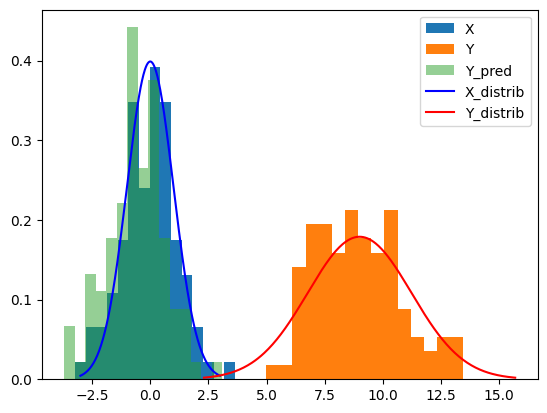

In [33]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C

test = 247
Y_pred  = ICNNf(X, C)[test, :, 0].detach().numpy()
print(Y_pred)


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(Y_pred,  bins=15, label = 'Y_pred', density = True, alpha = 0.5)
plt.plot(np.linspace(-3, 3, 300), stats.norm.pdf(np.linspace(-3, 3, 300), loc=0, scale=1), label = 'X_distrib', color = 'blue')
plt.plot(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), stats.norm.pdf(np.linspace(-3*scales[test, 0] + locs[test, 0], 3*scales[test, 0] + locs[test, 0], 300), loc=locs[test, 0], scale=scales[test, 0]), label = 'Y_distrib', color = 'red')

plt.legend()

plt.show()
         



